# Basic Information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 15 16:14:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

recognition/s45533675/Demo3.ipynb

Requirement: Implement a brain MRI super-resolution network by training on the ADNI brain dataset. Create down-sampled data (approximately by a factor of 4) using Tensorflow implementations. The network should be trained to up-scale from 4x down-sampled input and produce a “reasonably clear image".

# Set Up Environment


In [2]:
import tensorflow as tf
print("TF Version:", tf.__version__)

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

TF Version: 2.9.2


# Load data

Download dataset.
I use the built-in keras.utils.get_file utility to retrieve the dataset.

In [3]:
dataset_url = "https://cloudstor.aarnet.edu.au/plus/s/L6bbssKhUoUdTSI/download"
data_dir = keras.utils.get_file(origin=dataset_url, fname="ADNI", extract=True)


*   Because this task is not a classification problem, I just use the images in the AD train as my whole dataset.
*   The number of images is 10400 and it completely fits the training requirement.
*   The origin path is ADNI_AD_NC_2D\AD_NC\train\AD and I rename the ADNI_AD_NC_2D to ADNI and newpath is ADNI\AD_NC\train\AD.

In [4]:
root_dir = os.path.join("/root/.keras/datasets/AD_NC/train/AD")

Then I create training and validation datasets via image_dataset_from_directory.

The image size is 256 x 240. The number of images is 10400 so I choose 10% as validation set which is 1040.

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="grayscale",
    batch_size=64,
    image_size=(256, 240),
    shuffle=True,
    seed=1334,
    validation_split=0.1,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="grayscale",
    batch_size=64,
    image_size=(256, 240),
    shuffle=True,
    seed=1334,
    validation_split=0.1,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 10400 files belonging to 1 classes.
Using 9360 files for training.
Found 10400 files belonging to 1 classes.
Using 1040 files for validation.


# Pre process images

Normalization

I rescale the images to take values in the range [0, 1].

In [6]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_dataset = train_dataset.map(scaling)
valid_dataset = valid_dataset.map(scaling)

Demonstrate the first batch.

In [ ]:
for batch in train_dataset.take(1):
    for img in batch:
        display(array_to_img(img))
        print(img.shape)
        print(array_to_img(img))

I use images in AD_NC/test/AD as test images for visual evaluation at the end.


In [8]:
test_path = os.path.join("/root/.keras/datasets/AD_NC/test/AD")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpeg")
    ]
)

*   I downsample the original images to low-resolution images, and the original images are high-resolution images.
*   Set low-resolution images to 0 axis, high-resolution images to 1 axis.



In [9]:
upscale_factor = 4

def low_resolution(input, upscale_factor):

    return tf.image.resize(input, [256 // upscale_factor, 240 // upscale_factor], method="area")


def high_resolution(input):

    return input

train_dataset = train_dataset.map(
    lambda x: (low_resolution(x, upscale_factor), high_resolution(x))
)

valid_dataset = valid_dataset.map(
    lambda x: (low_resolution(x, upscale_factor), high_resolution(x))
)


Show the first processed batch.

(64, 60, 1)


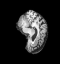

<PIL.Image.Image image mode=L size=60x64 at 0x7F876430B110>
(64, 60, 1)


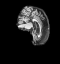

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641166D0>
(64, 60, 1)


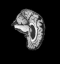

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764116990>
(64, 60, 1)


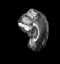

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641168D0>
(64, 60, 1)


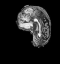

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764271BD0>
(64, 60, 1)


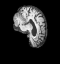

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764271E90>
(64, 60, 1)


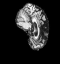

<PIL.Image.Image image mode=L size=60x64 at 0x7F87642677D0>
(64, 60, 1)


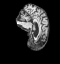

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641B8650>
(64, 60, 1)


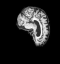

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764289590>
(64, 60, 1)


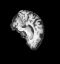

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764267E10>
(64, 60, 1)


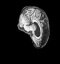

<PIL.Image.Image image mode=L size=60x64 at 0x7F8805510CD0>
(64, 60, 1)


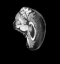

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764176410>
(64, 60, 1)


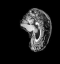

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102910>
(64, 60, 1)


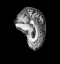

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764135F10>
(64, 60, 1)


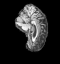

<PIL.Image.Image image mode=L size=60x64 at 0x7F87640EA110>
(64, 60, 1)


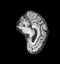

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641025D0>
(64, 60, 1)


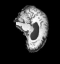

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102450>
(64, 60, 1)


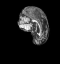

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102B90>
(64, 60, 1)


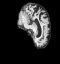

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102C50>
(64, 60, 1)


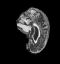

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102210>
(64, 60, 1)


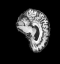

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641028D0>
(64, 60, 1)


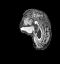

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102A90>
(64, 60, 1)


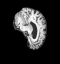

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641024D0>
(64, 60, 1)


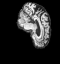

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641023D0>
(64, 60, 1)


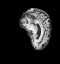

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764116E10>
(64, 60, 1)


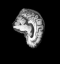

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641028D0>
(64, 60, 1)


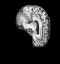

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102550>
(64, 60, 1)


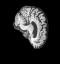

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102110>
(64, 60, 1)


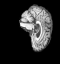

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102590>
(64, 60, 1)


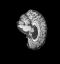

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102BD0>
(64, 60, 1)


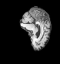

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102BD0>
(64, 60, 1)


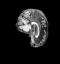

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764145490>
(64, 60, 1)


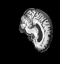

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102610>
(64, 60, 1)


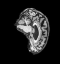

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102590>
(64, 60, 1)


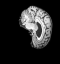

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764145B50>
(64, 60, 1)


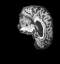

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764145490>
(64, 60, 1)


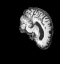

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102890>
(64, 60, 1)


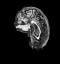

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102290>
(64, 60, 1)


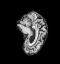

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102610>
(64, 60, 1)


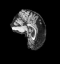

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102050>
(64, 60, 1)


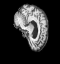

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764116890>
(64, 60, 1)


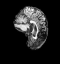

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764145B90>
(64, 60, 1)


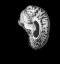

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764145490>
(64, 60, 1)


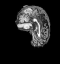

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641027D0>
(64, 60, 1)


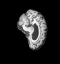

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641027D0>
(64, 60, 1)


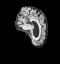

<PIL.Image.Image image mode=L size=60x64 at 0x7F87641027D0>
(64, 60, 1)


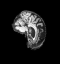

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102BD0>
(64, 60, 1)


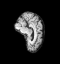

<PIL.Image.Image image mode=L size=60x64 at 0x7F87F0062B10>
(64, 60, 1)


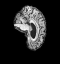

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764102890>
(64, 60, 1)


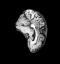

<PIL.Image.Image image mode=L size=60x64 at 0x7F87642677D0>
(64, 60, 1)


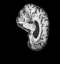

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764176490>
(64, 60, 1)


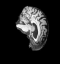

<PIL.Image.Image image mode=L size=60x64 at 0x7F87642677D0>
(64, 60, 1)


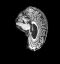

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117710>
(64, 60, 1)


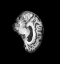

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117BD0>
(64, 60, 1)


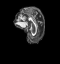

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117C50>
(64, 60, 1)


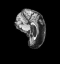

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117C50>
(64, 60, 1)


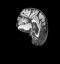

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117F90>
(64, 60, 1)


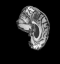

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117FD0>
(64, 60, 1)


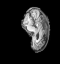

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117550>
(64, 60, 1)


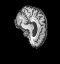

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117DD0>
(64, 60, 1)


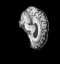

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117B90>
(64, 60, 1)


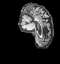

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117490>
(64, 60, 1)


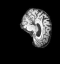

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117790>
(64, 60, 1)


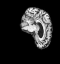

<PIL.Image.Image image mode=L size=60x64 at 0x7F8764117110>


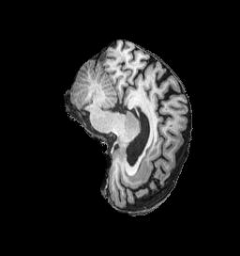

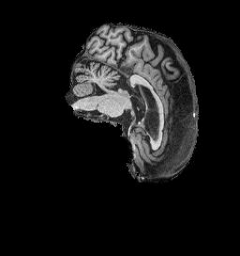

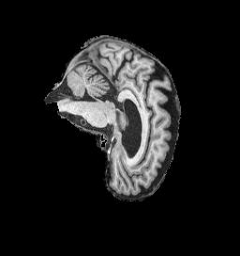

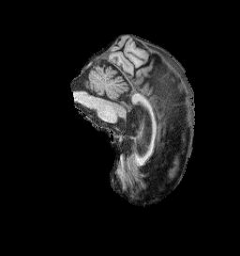

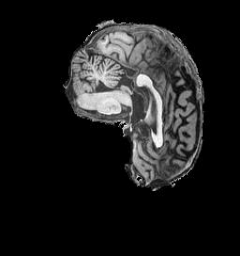

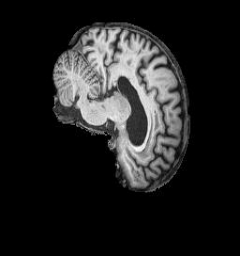

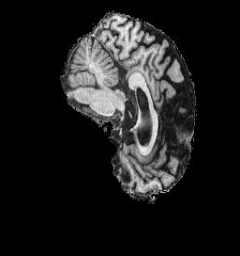

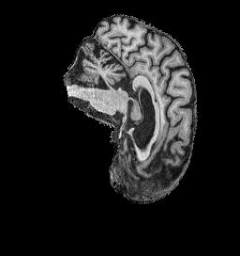

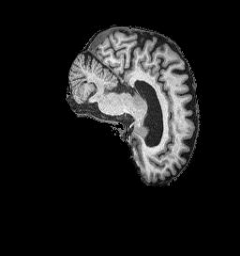

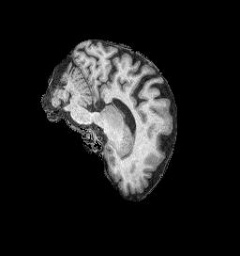

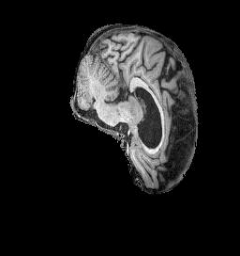

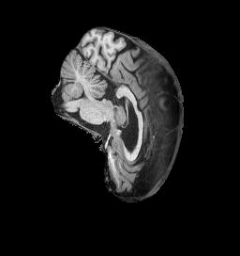

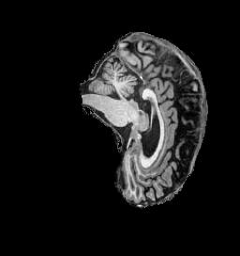

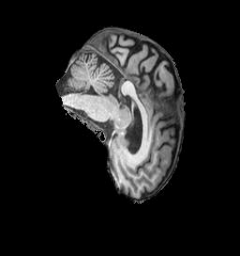

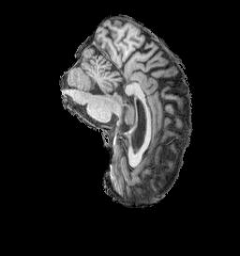

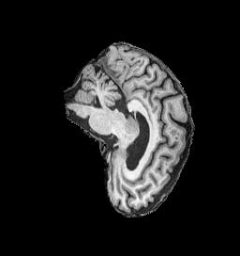

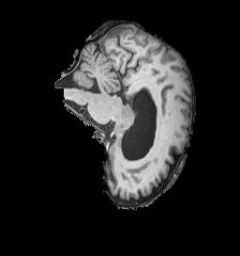

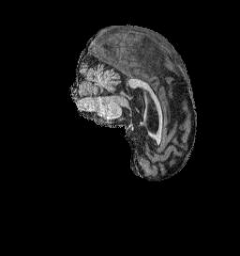

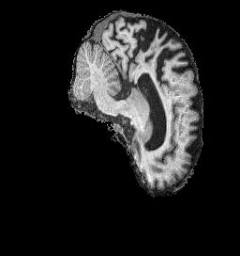

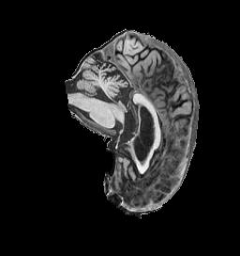

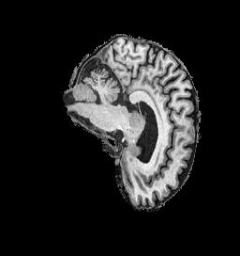

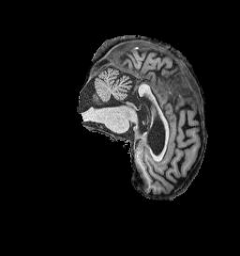

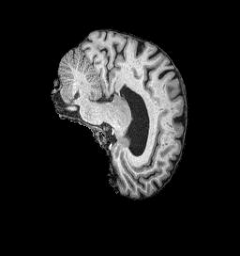

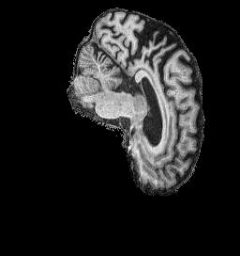

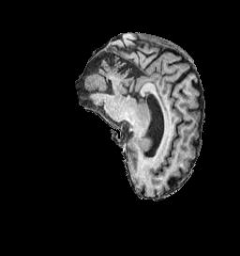

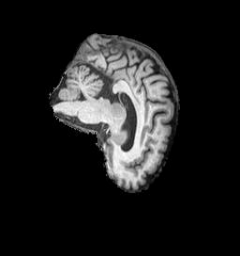

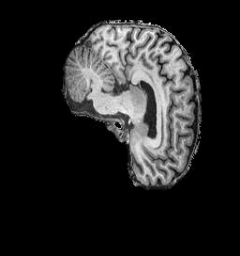

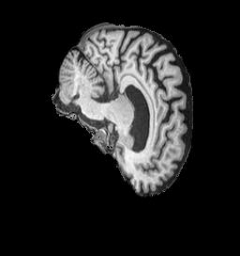

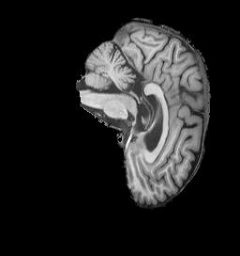

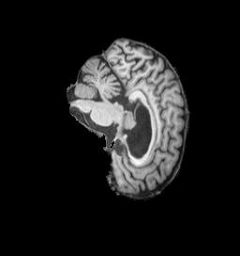

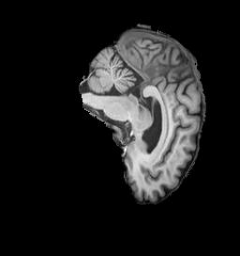

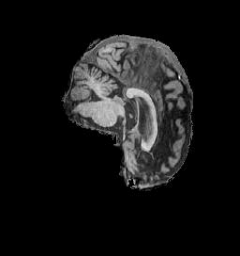

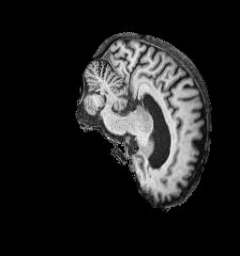

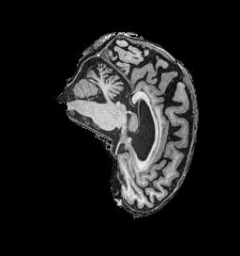

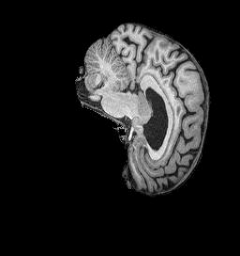

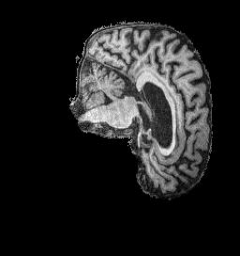

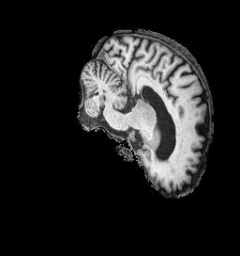

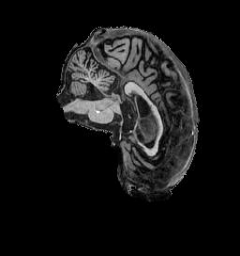

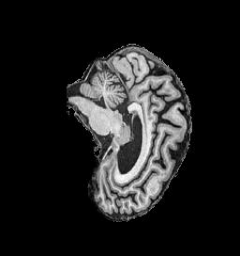

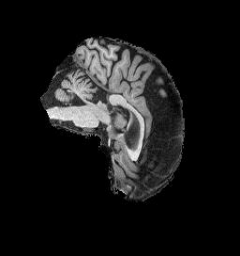

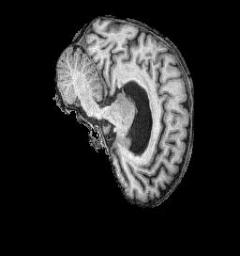

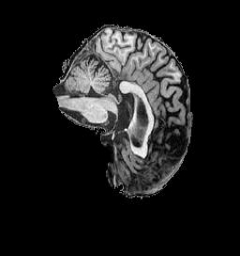

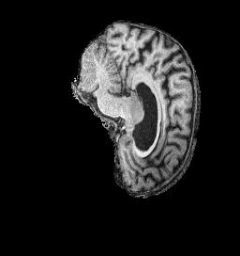

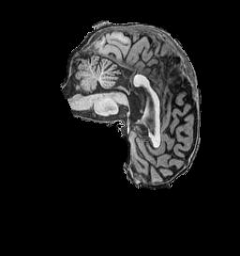

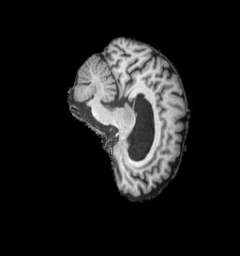

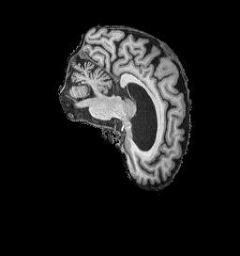

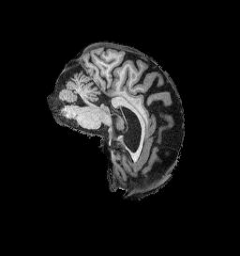

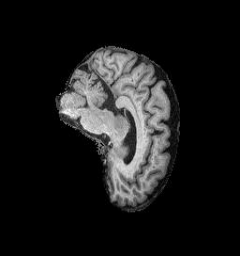

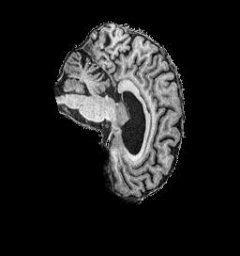

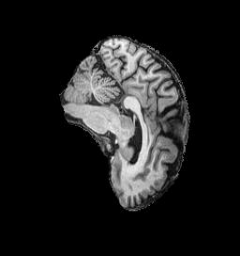

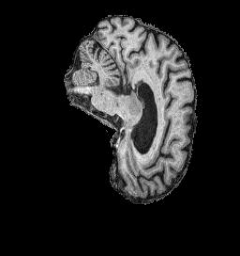

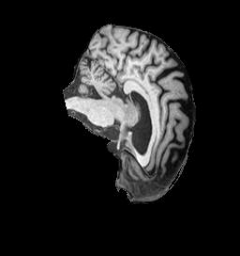

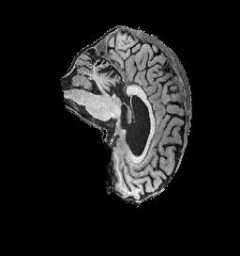

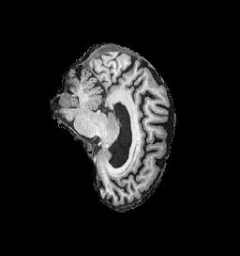

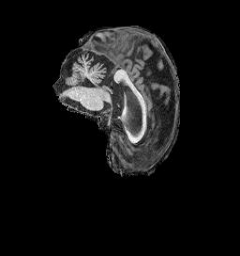

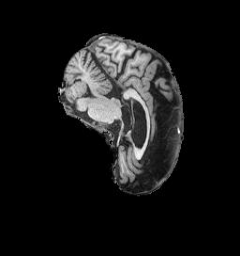

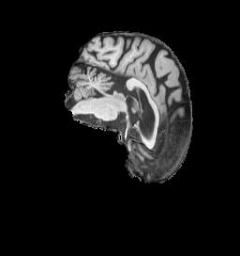

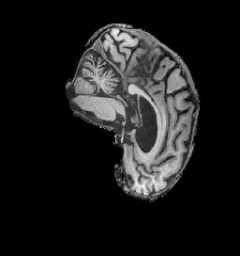

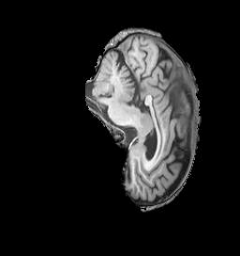

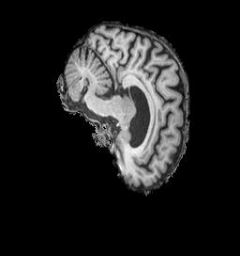

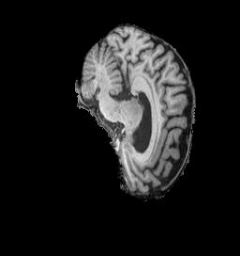

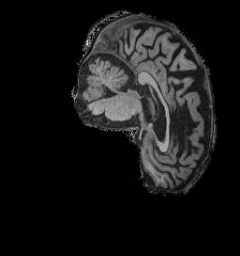

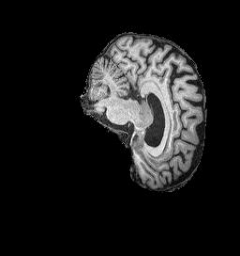

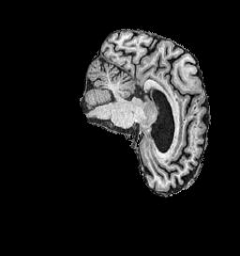

In [39]:
for batch in train_dataset.take(1):
    for img in batch[0]:
        print(img.shape)
        display(array_to_img(img))
        print(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


# Build the model

In [44]:
def get_model(upscale_factor=4, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(64, 60, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 60, 1)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 60, 64)        1664      
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 60, 64)        36928     
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 60, 32)        18464     
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 60, 16)        4624      
                                                                 
 tf.nn.depth_to_space_8 (TFO  (None, 256, 240, 1)      0         
 pLambda)                                                        
                                                           

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [23]:
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    img = img_to_array(img)
    img = img / 255.0

    input = np.expand_dims(img, axis=0)
    out = model.predict(input)

    out_img *= 255.0

    return out_img

In [24]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            #plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [25]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]

In [45]:
epochs = 200

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-06),loss='mean_squared_error')

model.fit(
    train_dataset, epochs=epochs, callbacks=callbacks, validation_data=valid_dataset, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/200
Mean PSNR for epoch: 27.50


ValueError: ignored